In [ ]:
!pip install iisignature

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp311-cp311-linux_x86_64.whl size=3246117 sha256=3b40d7e4282b361a0d9fe24305d5342f1e09298cc9ef4b1a2ba6c3b6491c84a5
  Stored in directory: /root/.cache/pip/wheels/1c/f4/57/0b4d3787a07f20a3cd1a91835d6247f55ef899345267bcd6df
Successfully built iisignature


In [ ]:
import numpy as np
import pandas as pd
import iisignature
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
print("Libraries loaded")

Libraries loaded


In [ ]:
def leadlag(X, use_time = False, print_arrays = False):
   if (not use_time):

       lead = []
       lag = []

       for val_lag, val_lead in zip(X[:-1], X[1:]):

           lead.append(val_lag)
           lag.append(val_lag)

           lead.append(val_lead)
           lag.append(val_lag)

       lead.append(X[-1])
       lag.append(X[-1])

       if (print_arrays):
           print(lead)
           print(lag)

       return np.c_[lead, lag]
   else:
       lead = []
       lag = []
       t = []

       time = 0

       t.append(time)
       lag.append(X[0])
       lead.append(X[0])

       for val_lag, val_lead in zip(X[:-1], X[1:]):

           time += 1

           t.append(time)
           lead.append(val_lag)
           lag.append(val_lag)

           t.append(time)
           lead.append(val_lead)
           lag.append(val_lag)

           t.append(time)
           lead.append(val_lead)
           lag.append(val_lead)

       if (print_arrays):
           print(lead)
           print(lag)
           print(t)

       return np.c_[lead, lag, t]

In [ ]:
def generatePoisson(n):
   lam = 0.25
   events = np.random.poisson(lam, n)
   counts = np.cumsum(events)
   return counts

def generateBrownian(n, delta=0.1):
   x = 0
   u = []
   for k in range(n):
       x = x + norm.rvs(scale=delta**2)
       u.append([x])
   return np.array(u)

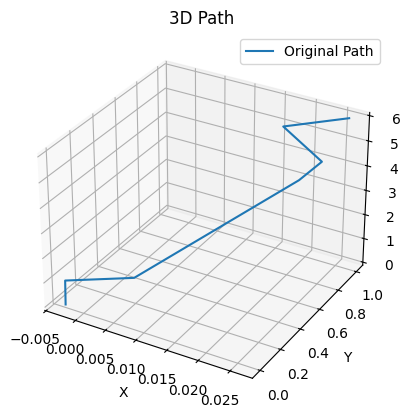

In [ ]:
def plot3D(path, recovered_path=None):
   fig = plt.figure()
   ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

   # Plot the path
   ax.plot(path[:, 0], path[:, 1], path[:, 2], label='Original Path')

   # Optionally, plot the recovered path
   if recovered_path is not None:
       ax.plot(recovered_path[:, 0], recovered_path[:, 1], recovered_path[:, 2], label='Recovered Path')

   ax.set_xlabel('X')
   ax.set_ylabel('Y')
   ax.set_zlabel('Z')
   ax.set_title('3D Path')
   ax.legend()

   plt.show()

def add_time(X):
   return np.c_[X, list(range(len(X)))]
n_points = 7
n_dims = 2
x = generateBrownian(n_points)
y = generatePoisson(n_points)
path = np.c_[x, y]
plot3D(add_time(path))


In [ ]:
def stream_to_logsig(X, order):
   X = np.array(X)
   s = iisignature.prepare(X.shape[1], order)
   return iisignature.logsig(X, s)

def data_transform(data):
   leadlag_path = leadlag(data)
   return leadlag_path

transformed_path = data_transform(path)
logsig = stream_to_logsig(transformed_path, 5)
print(len(logsig))
logsig = stream_to_logsig(transformed_path, 7)
print(len(logsig))
logsig = stream_to_logsig(transformed_path, 10)
print(len(logsig))

294
3304
145338


In [ ]:
path = pd.DataFrame()
pathSign = pd.DataFrame()

# Simulations
order = 10
for i in range(0, 500):
   transformed_path = data_transform(generateBrownian(70, 0.1))
   logsig = stream_to_logsig(transformed_path, order)
   pathSign = pd.concat([pathSign, pd.DataFrame(logsig.flatten(), columns=[i]).T], ignore_index=True)

   path = pd.concat([path, pd.DataFrame(generateBrownian(70, 0.1).flatten(), columns=[i]).T], ignore_index=True)

for i in range(501, 1000):
   transformed_path = data_transform(generateBrownian(70, 0.12))
   logsig = stream_to_logsig(transformed_path, order)
   pathSign = pd.concat([pathSign, pd.DataFrame(logsig.flatten(), columns=[i]).T], ignore_index=True)

   path = pd.concat([path, pd.DataFrame(generateBrownian(70, 0.12).flatten(), columns=[i]).T], ignore_index=True)

# Fitting
path['target'] = 0  # or pathSign
path.loc[501:, 'target'] = 1

X = path.drop('target', axis=1)
y = path['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier()  # Instantiate classifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.785
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        94
           1       0.82      0.75      0.79       106

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.78       200
weighted avg       0.79      0.79      0.79       200



In [ ]:
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import copy
import tensorflow as tf
import iisignature

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'GLD')

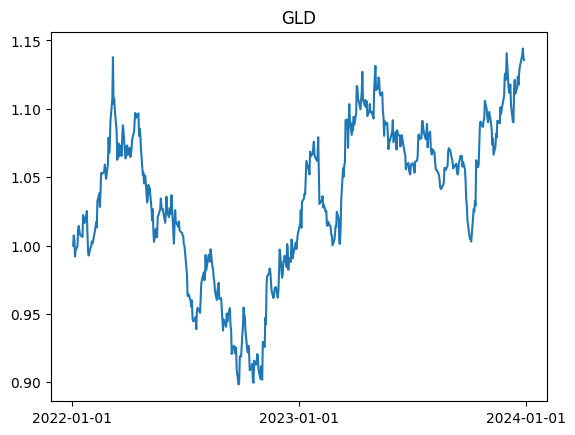

In [ ]:
ticker = "GlD"
start = datetime.date(2022, 1, 1)
end = datetime.date(2024, 1, 1)
data_gld = yf.download(ticker, start, end)["Close"]

plt.plot(data_gld / data_gld.iloc[0])

plt.xticks([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1), datetime.date(2024, 1, 1)])

plt.title('GLD')

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Gold')

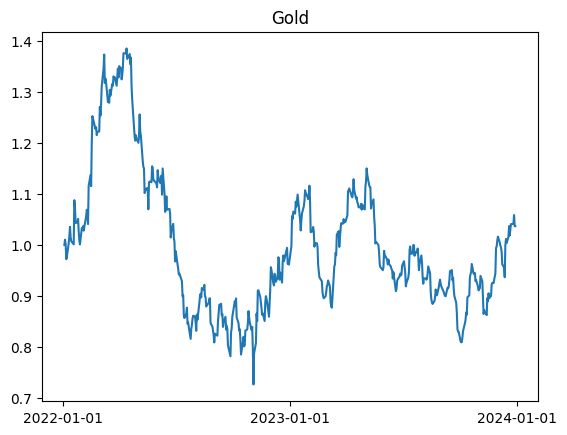

In [ ]:
ticker = "GOLD"
start = datetime.date(2022, 1, 1)
end = datetime.date(2024, 1, 1)

data_gold = yf.download(ticker, start, end)["Close"]

plt.plot(data_gold / data_gold.iloc[0])

plt.xticks([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1), datetime.date(2024, 1, 1)])

plt.title("Gold")


In [ ]:
class MarketGenerator:
   def __init__(self, n_dims, tickers_array, start, end, freq, signature_order, data_transform):
       self.n_dims = n_dims
       self.tickers_array = tickers_array
       self.start = start
       self.end = end
       self.freq = freq
       self.order = signature_order
       self.data_transform = data_transform

       self.load_data()
       self.build_dataset()
       self.transform_dataset()
       self.calculate_signatures()
       self.scale_dataset()

   def load_data(self):
       self.data_array = []
       for i in range(self.n_dims):
           data = yf.download(self.tickers_array[i],  self.start, self.end)["Close"]#.resample('M').last()
           self.data_array.append(data)
       self.windows_array = []

       for i in range(self.n_dims):
           windows = []
           for _, window in self.data_array[i].resample(self.freq):
               windows.append(window)
           self.windows_array.append(windows)

   def build_dataset(self):
       self.paths = []

       for i in range(len(self.windows_array[0])):
           if (self.n_dims > 1):
               df = pd.merge(self.windows_array[0][i], self.windows_array[1][i], left_index=True, right_index=True)

               for n in range (2, self.n_dims):
                   df = pd.merge(df, self.windows_array[n][i], left_index=True, right_index=True)
               path = np.c_[df.iloc[:, [0]].values, df.iloc[:, [1]].values]
               for n in range(2, self.n_dims):
                   path = np.c_[path, df.iloc[:, [n]].values]
               self.paths.append(path/path[0])
           else:
               self.paths.append(self.windows_array[0][i].values / self.windows_array[0][i].values[0])

   def transform_dataset(self):
       self.transformed_paths = []
       for path in self.paths:
           self.transformed_paths.append(self.data_transform(path))

   def calculate_signatures(self):
       self.orig_logsig = np.array([stream_to_logsig(path, self.order) for path in tqdm(self.transformed_paths)])

   def scale_dataset(self):
       self.scaler = MinMaxScaler(feature_range=(0.00001, 0.99999))
       scaled_logsig = self.scaler.fit_transform(self.orig_logsig)

       self.logsigs = scaled_logsig[1:]
       self.conditions = scaled_logsig[:-1] # needed later for CVAE

   def train(self, n_epochs=100):
       self.cvae = CVAE(n_latent=8, input_dim=self.logsigs.shape[1], cond_dim=self.conditions.shape[1], n_hidden=100, alpha=0.4)
       self.cvae.compile(optimizer='adam')
       self.cvae.fit(x=[self.logsigs, self.conditions], epochs=n_epochs)

   def generate_logsig(self, cond):
       generated = self.cvae.generate(cond)
       return self.scaler.inverse_transform(generated.reshape(1, -1))[0]

In [ ]:
n_dims = 2
tickers_array = ["GlD", "Gold"]
start = datetime.date(2022, 1, 1)
end = datetime.date(2024, 1, 1)
freq = "ME"
order = 5
def data_transform(data):
  leadlag_path =leadlag(data, use_time = True)
  return leadlag_path
MG = MarketGenerator(n_dims, tickers_array, start, end, freq, order, data_transform)
paths = MG.paths

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
100%|██████████| 24/24 [00:00<00:00, 273.27it/s]


In [ ]:
class Organism:
   def __init__(self, n_points, n_dims, data_transform, distribution_array):
       self.n_points = n_points
       self.n_dims = n_dims
       self.data_transform = data_transform

       self.distribution_array = distribution_array

       self.init_path()

   def __add__(self, other):
       increments = []
       for increment1, increment2 in zip(self.increments, other.increments):
           if np.random.random() < 0.5:
               increments.append(increment1)
           else:
               increments.append(increment2)

       path = np.cumsum(increments, axis = 0)
       transformed_path = self.data_transform(path)

       child = Organism(self.n_points, self.n_dims, self.data_transform, self.distribution_array)
       child.increments = increments
       child.path = path
       child.transformed_path = transformed_path

       return child

   def random_increment(self):
       r = []

       for dim in range(self.n_dims):
           r.append(self.distribution_array[dim]())

       return np.array(r)

   def init_path(self):
       self.increments = np.array([self.random_increment() for _ in range(self.n_points)])

       path = np.cumsum(self.increments, axis = 0)
       transformed_path = self.data_transform(path)

       self.path = path
       self.transformed_path = transformed_path

   def mutate(self, prob=0.1):
       for i in range(len(self.increments)):
           if np.random.random() < prob:
               self.increments[i] = self.random_increment()

       path = np.cumsum(self.increments, axis = 0)
       transformed_path = self.data_transform(path)

       self.path = path
       self.transformed_path = transformed_path

   def logsignature(self, order):
       return stream_to_logsig(self.transformed_path, order)

   def loss(self, logsig, order):
       diff = np.abs((logsig - self.logsignature(order)) / logsig)
       diff /= 1 + np.arange(len(logsig))

       return np.mean(diff)

In [ ]:
class Population:
   def __init__(self, n_organisms, n_points, n_dims, data_transform, distribution_array):
       self.n_organisms = n_organisms
       self.n_points = n_points
       self.n_dims = n_dims
       self.data_transform = data_transform

       self.distribution_array = distribution_array

       self.organisms = [Organism(n_points, n_dims, data_transform, distribution_array) for _ in range(n_organisms)]

   def fittest(self, logsig, p, order):
       n = int(len(self.organisms) * p)
       return sorted(self.organisms, key=lambda o: o.loss(logsig, order))[:n]

   def evolve(self, logsig, p, order, mutation_prob=0.1):
       parents = self.fittest(logsig, p, order)
       new_generation = copy.deepcopy(parents)

       while len(new_generation) != self.n_organisms:
           i = j = 0
           while i == j:
               i, j = np.random.choice(range(len(parents)), size=2)
               parent1, parent2 = parents[i], parents[j]

           child = parent1 + parent2 # function Organism._add
           child.mutate(prob=mutation_prob)

           new_generation.append(copy.deepcopy(child))

       self.organisms = new_generation

       return new_generation[0].loss(logsig, order)

   def train(logsig, order, n_iterations, n_organisms, n_points, n_dims, data_transform, distribution_array, top_p=0.1, mutation_prob=0.1):
       population = Population(n_organisms, n_points, n_dims, data_transform, distribution_array)
       pbar = tqdm(range(n_iterations))

       for _ in pbar:
           loss = population.evolve(logsig, p=top_p, order=order, mutation_prob=mutation_prob)
           pbar.set_description(f"Loss: {loss}")
           pbar.refresh()

           if loss == 0.:
               break

       return population.fittest(logsig, p=top_p, order=order)[0].path, loss

In [ ]:
n_dims = 2
n_points = 21

def distribution_x():
   pip = 0.001
   n_pips = 1/pip * 0.025
   return pip * np.random.randint(-n_pips, n_pips)

def distribution_y():
   pip = 0.001
   n_pips = 1/pip * 0.025
   return pip * np.random.randint(-n_pips, n_pips)

disribution_array = [distribution_x, distribution_y]

n_organisms = 250
n_iterations = 80

transformed_path = data_transform(paths[1])
logsig = stream_to_logsig(transformed_path, order)
recovered_path, loss = Population.train(logsig, order, n_iterations,
n_organisms, n_points, n_dims, data_transform, disribution_array)

Loss: 0.004235702481395033: 100%|██████████| 80/80 [01:30<00:00,  1.14s/it]


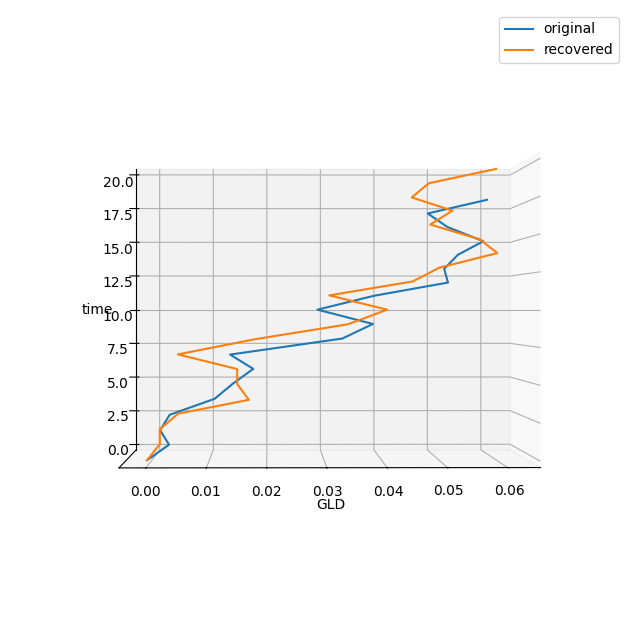

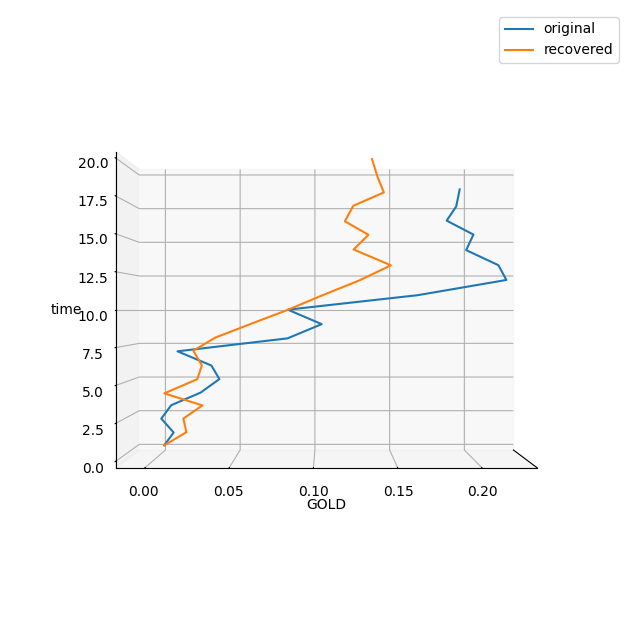

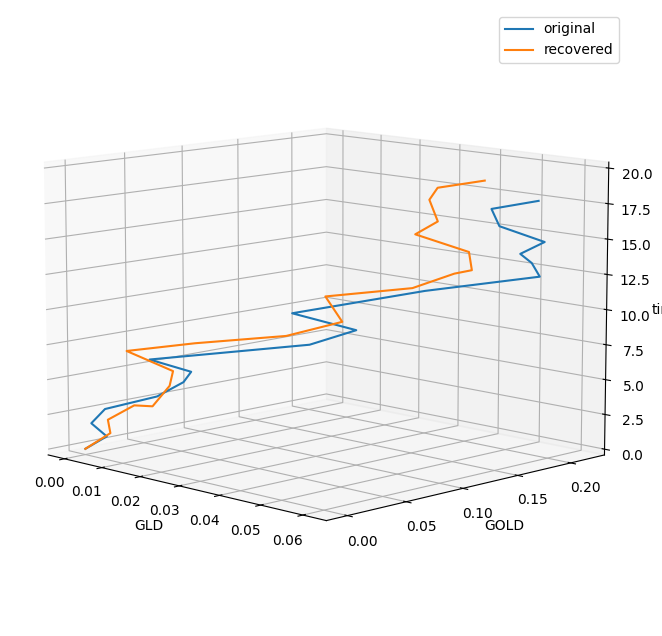

In [ ]:
label_x = "GLD"
label_y = "GOLD"

def plotAllProjections3D(filename, path, label_x, label_y, recovered_path=None):
   filename = filename
   plot3D(filename + "_" + label_x + ".png", [True, False], path, 0, -91, label_x, label_y, recovered_path)
   plot3D(filename + "_" + label_y + ".png", [False, True], path, 0, 0, label_x, label_y, recovered_path)
   plot3D(filename + "_" + label_x + "_" + label_y + ".png", [True, True], path, 10, -45, label_x, label_y, recovered_path)

def plot3D(filename, draw_tics, path, elev, azim, label_x, label_y, recovered_path=None):
   fig = plt.figure(figsize = (8, 8))
   ax = fig.add_subplot(111, projection='3d')
   ax.view_init(elev, azim)

   draw_path = path - path[0]
   ax.plot(draw_path[:, 0], draw_path[:, 1], draw_path[:, 2], label='original')

   if (recovered_path is not None):
       draw_recovered_path = recovered_path - recovered_path[0]
       ax.plot(draw_recovered_path[:, 0], draw_recovered_path[:, 1], draw_recovered_path[:, 2], label='recovered')

   if (draw_tics[0]):
       ax.set_xlabel(label_x)
   else:
       ax.set_xticks([])

   if (draw_tics[1]):
       ax.set_ylabel(label_y)
   else:
       ax.set_yticks([])

   ax.set_zlabel("time")

   ax.legend()
   fig.savefig(filename, bbox_inches='tight')

plotAllProjections3D("recover_path", add_time(paths[1]), label_x, label_y, add_time(recovered_path))

In [ ]:
class CVAE(tf.keras.Model):
   def __init__(self, n_latent, input_dim, cond_dim, n_hidden=50, alpha=0.2):
       super(CVAE, self).__init__()
       self.n_latent = n_latent
       self.input_dim = input_dim
       self.cond_dim = cond_dim
       self.n_hidden = n_hidden
       self.alpha = alpha
       self.encoder_net = self.build_encoder()
       self.decoder_net = self.build_decoder()

   def build_encoder(self):
       inputs = tf.keras.Input(shape=(self.input_dim,))
       cond = tf.keras.Input(shape=(self.cond_dim,))
       x = tf.keras.layers.Concatenate()([inputs, cond])
       x = tf.keras.layers.Dense(self.n_hidden, activation='relu')(x)
       mn = tf.keras.layers.Dense(self.n_latent, activation='relu')(x)
       sd = tf.keras.layers.Dense(self.n_latent, activation='relu')(x)
       return tf.keras.Model(inputs=[inputs, cond], outputs=[mn, sd])

   def build_decoder(self):
       latent = tf.keras.Input(shape=(self.n_latent,))
       cond = tf.keras.Input(shape=(self.cond_dim,))
       x = tf.keras.layers.Concatenate()([latent, cond])
       x = tf.keras.layers.Dense(self.n_hidden, activation='relu')(x)
       outputs = tf.keras.layers.Dense(self.input_dim, activation='sigmoid')(x)
       return tf.keras.Model(inputs=[latent, cond], outputs=outputs)

   def encode(self, x, cond):
       mn, sd = self.encoder_net([x, cond])
       batch_size = tf.shape(x)[0]
       epsilon = tf.random.normal(shape=(batch_size, self.n_latent))
       z = mn + epsilon * tf.exp(sd * 0.5)
       return z

   def decode(self, z, cond):
       return self.decoder_net([z, cond])

   def call(self, inputs):
       x, cond = inputs
       z = self.encode(x, cond)
       reconstructed = self.decode(z, cond)
       return reconstructed

   def compute_loss(self, x, reconstructed, mn, sd):
       cross_ent = tf.keras.losses.binary_crossentropy(x, reconstructed)
       kl_div = -0.5 * tf.reduce_sum(1. + sd - tf.square(mn) - tf.exp(sd), axis=-1)
       return tf.reduce_mean(cross_ent + self.alpha * kl_div)

   def train_step(self, data):
       x, cond = data[0]
       with tf.GradientTape() as tape:
           z = self.encode(x, cond)
           reconstructed = self.decode(z, cond)
           mn, sd = self.encoder_net([x, cond])
           loss = self.compute_loss(x, reconstructed, mn, sd)
       gradients = tape.gradient(loss, self.trainable_variables)
       self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
       return {'loss': loss}

   def generate(self, cond, n_samples=None):
       cond = np.asarray(cond, dtype=np.float32)

       if n_samples is not None:
           randoms = np.random.normal(0, 1, size=(n_samples, self.n_latent))
           cond = np.repeat(cond[np.newaxis, :], n_samples, axis=0)
       else:
           randoms = np.random.normal(0, 1, size=(1, self.n_latent))
           cond = cond[np.newaxis, :]

       z = self.decode(randoms, cond)
       return z.numpy()

In [ ]:
conditions = MG.conditions

MG.train(1000)

array = []
for cond in conditions:
   array.append(MG.generate_logsig(cond))

array = np.array(array)

print(np.mean(array), np.mean(MG.orig_logsig))
print(np.max(array), np.max(MG.orig_logsig))
print(np.min(array), np.min(MG.orig_logsig))
print(np.median(array), np.median(MG.orig_logsig))
print(np.std(array), np.std(MG.orig_logsig))
print(np.var(array), np.var(MG.orig_logsig))

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.7812
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3746
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3441
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3411
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3372
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3337
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3296
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3255
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3216
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3182
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3149
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3119
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.3092
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3069
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3046
Epoch 

In [ ]:
generated_paths = []

for _ in range(10):
   logsig = MG.generate_logsig(conditions[3])
   recovered_path, loss = Population.train(logsig, order, n_iterations, n_organisms, n_points, n_dims, data_transform, disribution_array)

   generated_paths.append(recovered_path)

Loss: 0.005817591467356089: 100%|██████████| 80/80 [01:31<00:00,  1.14s/it]


In [ ]:
generate_count = 6

generated_paths = []
for cond in tqdm(conditions[:generate_count]):
   for _ in range(10):
       logsig = MG.generate_logsig(cond)
       recovered_path, loss = Population.train(logsig, order, n_iterations, n_organisms, n_points, n_dims, data_transform, disribution_array)

       generated_paths.append(recovered_path)

Loss: 0.006405021508322589: 100%|██████████| 80/80 [01:37<00:00,  1.21s/it]

Loss: 0.00650766995494575: 100%|██████████| 80/80 [01:31<00:00,  1.15s/it]

Loss: 0.006211118097225461: 100%|██████████| 80/80 [01:32<00:00,  1.15s/it]

Loss: 0.00645303960268454: 100%|██████████| 80/80 [01:32<00:00,  1.16s/it]

Loss: 0.005942045488795949: 100%|██████████| 80/80 [01:32<00:00,  1.16s/it]

Loss: 0.00612355109892481: 100%|██████████| 80/80 [01:34<00:00,  1.18s/it]

Loss: 0.006258093113386835: 100%|██████████| 80/80 [01:34<00:00,  1.18s/it]

Loss: 0.006680411033793771: 100%|██████████| 80/80 [01:34<00:00,  1.19s/it]

Loss: 0.006357583826092755: 100%|██████████| 80/80 [01:35<00:00,  1.19s/it]

Loss: 0.005557844574084864: 100%|██████████| 80/80 [01:35<00:00,  1.19s/it]

Loss: 0.005232523172692804: 100%|██████████| 80/80 [01:35<00:00,  1.19s/it]

Loss: 0.005059675036702152: 100%|██████████| 80/80 [01:36<00:00,  1.20s/it]

Loss: 0.005448679586153806: 100%|██████████| 80/80 [01:38<00:00,  1.24s/it]

 1

KeyboardInterrupt: 